# Simple pendulum

In [20]:
import os, sys

path_to_add = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.append(path_to_add)
print(os.path.join(path_to_add, "daeFinder"))
sys.path.append(os.path.join(path_to_add, "daeFinder"))


import numpy as np
from scipy.integrate import odeint
import pandas as pd
import warnings
pd.set_option('display.float_format', '{:0.8f}'.format)
import operator
import sympy
from dae_finder import construct_reduced_fit_list

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp




from matplotlib import pyplot as plt
from dae_finder import smooth_data
from dae_finder import add_noise_to_df
from sklearn import decomposition
from sklearn.linear_model import LinearRegression
from dae_finder import get_simplified_equation_list
from dae_finder import get_refined_lib, remove_paranth_from_feat
from dae_finder import AlgModelFinder
from dae_finder import sequentialThLin, AlgModelFinder
from dae_finder import PolyFeatureMatrix
from copy import deepcopy



/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder


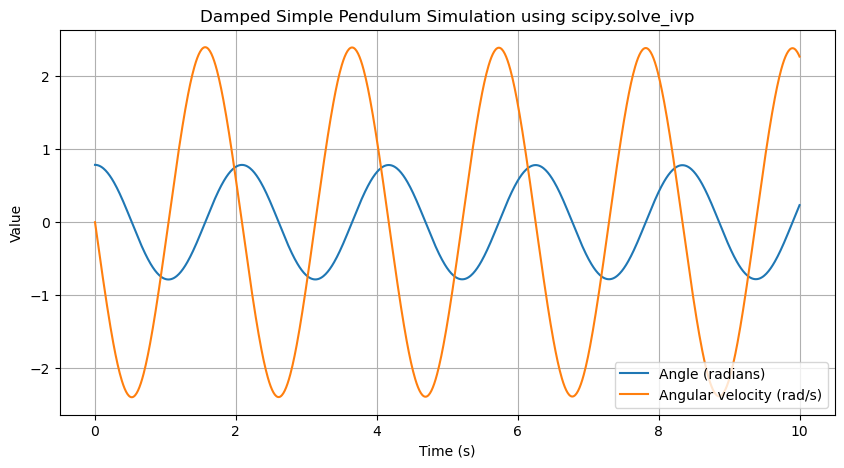

In [75]:


# Function to compute derivatives
def pendulum_rhs(t, y, gamma, L=1):
    """
    Function to compute derivatives for simple pendulum with damping
    
    Parameters:
        t : float
            Time
        y : array_like
            Vector containing [theta, omega], where
            theta is the angle and omega is the angular velocity
        gamma : float
            Damping coefficient
        L : float
            Length of the pendulum
        
    Returns:
        dydt : array_like
            Vector containing [omega, alpha], where
            omega is the angular velocity and alpha is the angular acceleration
    """
    theta, omega = y
    alpha = - (9.81 / L) * np.sin(theta) - gamma * omega
    return [omega, alpha]

# Parameters
theta0 = np.pi / 4  # Initial angle (radians)
omega0 = 0.0        # Initial angular velocity (radians per second)
gamma = 0.0       # Damping coefficient
L = 1.0             # Length of the pendulum (meters)
t_span = (0, 10)    # Time span for the simulation

# Function to integrate the system of ODEs
def integrate_pendulum(t_span, y0, gamma, L):

    sol = solve_ivp(lambda t, y: pendulum_rhs(t, y, gamma, L), t_span, y0, method='RK45', t_eval=np.linspace(*t_span, 1000))
    return sol

# Integrate the pendulum system
sol = integrate_pendulum(t_span, [theta0, omega0], gamma, L)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(sol.t, sol.y[0], label='Angle (radians)')
plt.plot(sol.t, sol.y[1], label='Angular velocity (rad/s)')
plt.title('Damped Simple Pendulum Simulation using scipy.solve_ivp')
plt.xlabel('Time (s)')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

wrong_relation_dict = {}

In [76]:
IC_df = pd.read_csv(os.path.join(path_to_add, "parameters/init_cond_simp_pend.csv"))
# IC_df = IC_df.iloc[[0,3]]
params_df = pd.read_csv(os.path.join(path_to_add, "parameters/pend_param.csv"))
g = 9.81   # Acceleration due to gravity (m/s^2)

### Synthesizing data from different ICs

In [77]:
L = 10
# y_shift = 0.9 * L
# y_shift = 0
noise_perc = 0
wrong_relation_dict[noise_perc] = []

num_time_points = 10000
# Time span
t_span = (0.0, 10)  # from 0 to 10 seconds
#Valuation points
t_eval_ = np.linspace(t_span[0], t_span[1], num_time_points)
data_matrix_df_list = []


for param_index in params_df.index:
    params = params_df.loc[param_index]
    # Define parameters
    m_c = params['m_c']  # Mass of the cart (kg)
    m_p = params['m_p']  # Mass of the pendulum (kg)
    l = params['l']    # Length of the pendulum (m)
    for IC_index in IC_df.index:
        IC = IC_df.loc[IC_index]
        y0 = IC.values
                # Parameters
        theta0 = IC["theta"]  # Initial angle (radians)
        omega0 = IC["omega"]        # Initial angular velocity (radians per second)
        gamma = 0.1         # Damping coefficient
        # Solve the ODEs
        # sol = solve_ivp(lambda t, y: pendulum_rhs(t, y, gamma, L), t_span, [theta0, omega0], method='RK45', t_eval=t_eval_)
        sol = solve_ivp(lambda t, y: pendulum_rhs(t, y, gamma, L), t_span, [theta0, omega0], t_eval=t_eval_, rtol=1e-12)
        
        sol_df = pd.DataFrame(sol.y.T, columns=["theta", "omega"])
        sol_df["x"] = L*np.sin(sol_df["theta"])
        sol_df["y"] = -L*np.cos(sol_df["theta"])
        sol_df["t"] = t_eval_
        data_matrix_df_list.append(sol_df[["t", "x", "y","theta", "omega"]])
        # data_matrix_df_list.append(sol_df[["t", "x", "y"]])

        # if IC_index == 0:
        #     # Plot the results
        #     plt.figure(figsize=(10, 6))
        #     plt.plot(sol.t, sol.y[0], label='Cart Position (x)')
        #     plt.plot(sol.t, sol.y[2], label='Pendulum Angle (theta)')
        #     plt.xlabel('Time (s)')
        #     plt.ylabel('Position (m) / Angle (rad)')
        #     plt.title('Upright Pendulum on Moving Cart')
        #     plt.legend()
        #     plt.grid(True)
        #     plt.show()

data_matrix_df = pd.concat(data_matrix_df_list, ignore_index=True)
print("# data points per IC: {}".format(data_matrix_df.shape[0]/len(IC_df)))


# Adding noise to time-series
sys.path.append(os.path.join(path_to_add, "daeFinder"))

data_matrix_features = data_matrix_df_list[0].columns
for ind, data_matrix_ in enumerate(data_matrix_df_list):
    t_exact = data_matrix_["t"]
    np.random.seed(1)
    noise_arr = np.random.normal(size=data_matrix_.shape)
    noisy_data_df = data_matrix_ + (noise_perc/100)*(abs(data_matrix_))*noise_arr
    noisy_data_df = add_noise_to_df(data_matrix_, noise_perc=noise_perc, random_seed=111)

    noisy_data_df["t"] = t_exact
    data_matrix_df_list[ind] = noisy_data_df


## Plotting noisy times-series
# plt.plot(data_matrix_df_list[3]["t"], data_matrix_df_list[3]["x"], data_matrix_df_list[3]["t"], data_matrix_df_list[3]["y"])


# data points per IC: 10000.0


### Smoothing data and finding derivatives

In [18]:
from scipy import interpolate
import itertools

def der_label(feature, der=1):
    if der == 0:
        return feature
    elif der == 1:
        return "d({}) /dt".format(feature)
    else:
        return "d^{}({}) /dt^{}".format(der, feature, der)

from scipy.signal import savgol_filter 
    
def smooth_data(data_matrix,
                domain_var="t",
                smooth_method ="spline",
                s_param_=None,
                noise_perc=0,
                derr_order=1,
                eval_points=[],
                num_time_points=0,
                polyorder=2,
                window_smooth=None
                ):
    """
    :param data_matrix: Data matrix to smoothen. nxp data frame structure is assumed where n is the number of
                        data points and p is the number of features (predictors).
    :param domain_var: Domain variable with respect to which the data needs to be smoothened. Default is assumed to be
                        "t" (time).
    :param smooth_method: Numerical method used for smoothening.
    :param s_param: smoothening parameter.
    :param noise_perc: optional estimate of noise to signal ratio %
    :param derr_order: Number of derivatives need to be calculated, wrt the domain variable, after smoothening the data.
    :param eval_points: option list of points at which the smoothened data and derivatives will be evaluated for output
    :return: pd.DataFrame of size len(eval_points) x k where k is the number of features and their derivatives.
    """
    assert domain_var in data_matrix, "domain variable not found in the data matrix"
    assert len(data_matrix)>3, "At least 3 data points required for smoothening"
    s_param = deepcopy(s_param_)
    data_t = data_matrix[domain_var]
    if num_time_points == 0:
        num_time_points = len(data_matrix)
    if len(eval_points) == 0:
        eval_points = np.linspace(data_t.iloc[0], data_t.iloc[-1], num_time_points)
    t_eval_new = eval_points

    data_matrix_ = data_matrix.drop(domain_var, axis=1)
    data_matrix_std = data_matrix_.std()


    if smooth_method == "spline":
        data_matrix_smooth = pd.DataFrame(t_eval_new, columns=[domain_var])
        if s_param:
            s_param_list = [s_param for feature in data_matrix_]
        else:
            s_param_list = [num_time_points * (0.01 * noise_perc * data_matrix_std[feature]) ** 2 for
                            feature in data_matrix_]
        smoothened_values_list = [np.hstack([interpolate.splev(t_eval_new, interpolate.splrep(data_t,
                                                                                              data_matrix_[feature],
                                                                                              s=s_param_val), der=der_ind) [:, None]
                                             for der_ind in range(derr_order + 1)])
                                  for feature, s_param_val in zip(data_matrix_, s_param_list)]
        smoothened_values = np.hstack(smoothened_values_list)
        column_label_list = [[der_label(feature, der_ind) for der_ind in range(derr_order + 1)]
                             for feature in data_matrix_]
        column_label_list = list(itertools.chain.from_iterable(column_label_list))
        smoothened_df = pd.DataFrame(smoothened_values, columns=column_label_list)
        data_matrix_smooth = pd.concat([data_matrix_smooth, smoothened_df], axis=1)
        return data_matrix_smooth

    elif smooth_method == "SG": #Savitzky-Golay filler for smooth derivatives
        if not window_smooth:
            window_size = len(data_t)//15
        else:
            window_size = len(data_t)//window_smooth
        assert polyorder<window_size, "Polynomial degreee for interpolation must be less than window length"
        data_matrix_smooth = pd.DataFrame(data_t, columns=[domain_var])
        delta_t = data_t[1] - data_t[0] #Spacing of data (assumed to be uniform)

        smoothened_values_list = [np.column_stack([savgol_filter(data_matrix_[feature], window_length=window_size, polyorder=polyorder,
                            deriv=der_ind, delta=delta_t)
                                    for der_ind in range(derr_order + 1)])
                                    for feature in data_matrix_]
        smoothened_values = np.column_stack(smoothened_values_list)
        column_label_list = [[der_label(feature, der_ind) for der_ind in range(derr_order + 1)]
                                for feature in data_matrix_]
        column_label_list = list(itertools.chain.from_iterable(column_label_list))
        smoothened_df = pd.DataFrame(smoothened_values, columns=column_label_list)
        data_matrix_smooth = pd.concat([data_matrix_smooth, smoothened_df], axis=1)
        return data_matrix_smooth
    else:
        raise "Smoothening type not supported"

In [79]:


data_amplify_fact = 1
num_smoothed_points = num_time_points*data_amplify_fact

t_eval_new = np.linspace(data_matrix_df_list[0]["t"].iloc[0], data_matrix_df_list[0]["t"].iloc[-1], num_smoothed_points)

#Calling the smoothening function
# data_matrix_smooth_df_list = [smooth_data(data_matrix,derr_order=1, noise_perc=noise_perc, s_param_=s_param, eval_points=t_eval_new) for data_matrix in data_matrix_df_list]
data_matrix_smooth_df_list = [
    smooth_data(data_matrix,
                domain_var="t",
                smooth_method ="SG",
                noise_perc=noise_perc,
                derr_order=2,
                polyorder=2,
                window_smooth=None)
    for data_matrix in data_matrix_df_list]


if len(data_matrix_smooth_df_list) == 1:
    data_matrix_df_smooth_appended = data_matrix_smooth_df_list[0]
else:
    data_matrix_df_smooth_appended = pd.concat(data_matrix_smooth_df_list, ignore_index=True)

data_matrix_df_smooth = data_matrix_df_smooth_appended[["x","y", "d(x) /dt", "d(y) /dt"]]
data_matrix_df_smooth["x"] = data_matrix_df["x"]
data_matrix_df_smooth["y"] = data_matrix_df["y"]
# data_matrix_df_smooth = data_matrix_df_smooth.iloc[5:-5]

# Removing big bumps in the time series due to noise
new_df = deepcopy(data_matrix_df_smooth)
new_df["energy"] = 0.5*((new_df["d(x) /dt"])**2 + (new_df["d(y) /dt"])**2) +  9.81*new_df["y"]
data_matrix_df_smooth = data_matrix_df_smooth[abs(new_df["energy"]-new_df["energy"].mean()) < 0.5*new_df["energy"].std()]
data_matrix_df_smooth = data_matrix_df_smooth.rename(columns= dict(zip(data_matrix_df_smooth, ['x', 'y', 'x_dot', 'y_dot'])))
print("length of the filtered time-series after removing bumps in dx/dt: {}".format(len(data_matrix_df_smooth)//len(IC_df)))


data_matrix_second_der_df = data_matrix_df_smooth_appended[['d^2(x) /dt^2', 'd^2(y) /dt^2']][abs(new_df["energy"]-new_df["energy"].mean()) < 0.5*new_df["energy"].std()]

# #Plotting smoothened splines

# ind = 1
# feature_ = "y"

# plt.figure()
# # plt.plot(data_matrix_df_list[1]["t"], data_matrix_df_list[1]["x"], "x", t_eval_new, x_new,
# #         data_matrix_df[50:100]["t"], data_matrix_df[50:100]["x"], "o")

# plt.plot(data_matrix_df_list[ind]["t"], data_matrix_df_list[ind][feature_], "x", data_matrix_smooth_df_list[ind]["t"],
#          data_matrix_smooth_df_list[ind][feature_],data_matrix_df[ind*num_time_points:(ind+1)*num_time_points]["t"], data_matrix_df[ind*num_time_points:(ind+1)*num_time_points][feature_], "o")
# plt.legend(['Noisy', 'Cubic Spline', 'True'])
# # plt.axis([-0.05, 6.33, -1.05, 1.05])
# plt.title('Cubic-spline interpolation of {} - Noise: {}%'.format(feature_, noise_perc))
# plt.show()

# data_matrix_smooth_df_list[0][["d(x) /dt"]].plot()

length of the filtered time-series after removing bumps in dx/dt: 3726


/var/folders/1h/sr7kc8_d5pddvym2zw5gv28r0000gn/T/ipykernel_33207/1724572951.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_matrix_df_smooth["x"] = data_matrix_df["x"]
/var/folders/1h/sr7kc8_d5pddvym2zw5gv28r0000gn/T/ipykernel_33207/1724572951.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_matrix_df_smooth["y"] = data_matrix_df["y"]


In [ ]:
# data_matrix_df_smooth_appended.columns

Index(['t', 'x', 'd(x) /dt', 'd^2(x) /dt^2', 'y', 'd(y) /dt', 'd^2(y) /dt^2',
       'theta', 'd(theta) /dt', 'd^2(theta) /dt^2', 'omega', 'd(omega) /dt',
       'd^2(omega) /dt^2'],
      dtype='object')

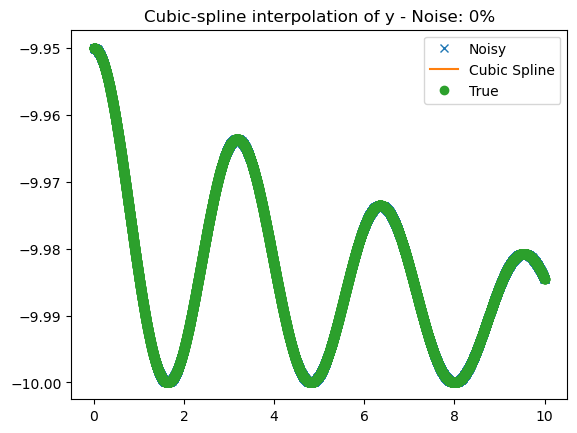

In [ ]:
# ind = 0
# feature_ = "y"

# plt.figure()
# # plt.plot(data_matrix_df_list[1]["t"], data_matrix_df_list[1]["x"], "x", t_eval_new, x_new,
# #         data_matrix_df[50:100]["t"], data_matrix_df[50:100]["x"], "o")

# plt.plot(data_matrix_df_list[ind]["t"], data_matrix_df_list[ind][feature_], "x", data_matrix_smooth_df_list[ind]["t"],
#          data_matrix_smooth_df_list[ind][feature_],data_matrix_df[ind*num_time_points:(ind+1)*num_time_points]["t"], data_matrix_df[ind*num_time_points:(ind+1)*num_time_points][feature_], "o")
# plt.legend(['Noisy', 'Cubic Spline', 'True'])
# # plt.axis([-0.05, 6.33, -1.05, 1.05])
# plt.title('Cubic-spline interpolation of {} - Noise: {}%'.format(feature_, noise_perc))
# plt.show()

In [ ]:
# new_df = deepcopy(data_matrix_df_smooth)
# new_df["energy"] = 0.5*((new_df["x_dot"])**2 + (new_df["y_dot"])**2) +  9.81*new_df["y"]

# new_df["dx/dt_exact"] = -new_df['y']*data_matrix_df['omega']
# new_df["dy/dt_exact"] = new_df['x']*data_matrix_df['omega']

# new_df["energy_exact"] = 0.5*((new_df["dx/dt_exact"])**2 + (new_df["dy/dt_exact"])**2) +  9.81*data_matrix_df["y"]
# # new_df_2 = new_df[abs(new_df["energy"]-new_df["energy"].mean()) < 0.5*new_df["energy"].std()]

# feature = "y"
# # plt.plot(data_matrix_df["t"][:num_time_points], data_matrix_df_smooth["{}_dot".format(feature)][:num_time_points] , label="smoothened {}_dot".format(feature))
# # plt.plot(data_matrix_df["t"][:num_time_points], new_df["d{}/dt_exact".format(feature)][:num_time_points] ,label="d{}/dt_exact".format(feature))
# # plt.legend()


<Axes: >

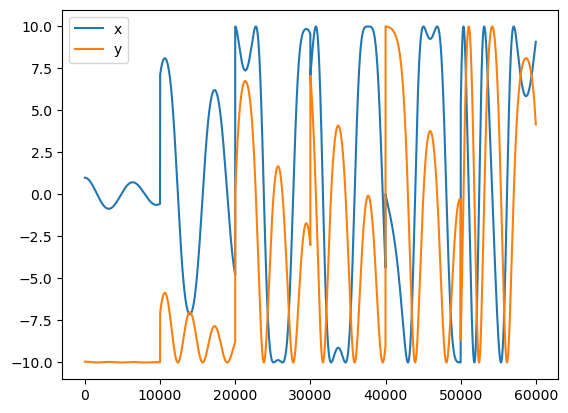

In [ ]:
# data_matrix_df[["x","y"]].plot()

In [ ]:
from scipy.signal import savgol_filter

data_matrix = data_matrix_df_list[0]
# # Extract numpy arrays
# t = df_["t"].to_numpy()
# x = df_["x"].to_numpy()
# y = df_["y"].to_numpy()

# Compute sampling interval assuming uniform time steps
# dt = df_["t"][1] - df_["t"][0]

# Choose Savitzky–Golay parameters
window_length = num_time_points//15   # Must be odd, e.g. 5, 7, 9, ...
polyorder = 2        # Usually smaller than window_length

# # First derivative wrt t for x(t)
# dx_dt = savgol_filter(x, window_length=window_length, polyorder=polyorder,
#                       deriv=1, delta=dt)

# # First derivative wrt t for y(t)
# dy_dt = savgol_filter(y, window_length=window_length, polyorder=polyorder,
#                       deriv=1, delta=dt)

# # Put results back into the DataFrame
# df_["dx/dt"] = savgol_filter(df_["x"], window_length=window_length, polyorder=polyorder,
#                       deriv=1, delta=dt)
# df_["dy/dt"] = savgol_filter(df_["y"], window_length=window_length, polyorder=polyorder,
#                       deriv=1, delta=dt)

derr_order = 1
data_t = data_matrix["t"]
delta_t = data_matrix["t"][1] - data_matrix["t"][0]
t_eval_new = data_t

# t_eval_new = eval_points

data_matrix_ = data_matrix.drop("t", axis=1)
data_matrix_smooth = pd.DataFrame(t_eval_new, columns=["t"])



smoothened_values_list = [np.column_stack([savgol_filter(data_matrix_[feature], window_length=window_length, polyorder=polyorder,
                       deriv=der_ind, delta=delta_t)
                            for der_ind in range(derr_order + 1)])
                            for feature in data_matrix_]
smoothened_values = np.column_stack(smoothened_values_list)
column_label_list = [[der_label(feature, der_ind) for der_ind in range(derr_order + 1)]
                        for feature in data_matrix_]
column_label_list = list(itertools.chain.from_iterable(column_label_list))
smoothened_df = pd.DataFrame(smoothened_values, columns=column_label_list)
data_matrix_smooth = pd.concat([data_matrix_smooth, smoothened_df], axis=1)

In [ ]:
# 

## Forming candiate library

In [ ]:
# len(data_matrix_df_list[0])

10000

In [ ]:
# data_matrix_df["d(x) /dt"] = -data_matrix_df['y']*data_matrix_df['omega']
# data_matrix_df["d(y) /dt"] = data_matrix_df['x']*data_matrix_df['omega']
# # data_matrix_df_new = data_matrix_df[["x","y", "d(x) /dt", "d(y) /dt"]]
# data_matrix_df_new = data_matrix_df[["x","y", "theta", "omega"]]

# # data_matrix_df_new = data_matrix_df_new.rename(columns= dict(zip(data_matrix_df_new, ['x', 'y', 'x_dot', 'y_dot'])))

In [ ]:
# poly_degree = 3

# poly_feature_ob = PolyFeatureMatrix(poly_degree)
# candidate_lib_full = poly_feature_ob.fit_transform(data_matrix_df_new)
# # candidate_lib_full = poly_feature_ob.fit_transform(data_matrix_df_smooth)





# candidate_lib_full = candidate_lib_full.drop(["1"], axis=1)
# print("Degree of library: {}".format(poly_degree))
# print("# terms in the library: {}".format(candidate_lib_full.shape[1]))

# #Optionally removing features from the library
# terms_to_drop_corr = set()
# candidate_lib_full = candidate_lib_full.drop(terms_to_drop_corr, axis=1)
# print("Full candidate library has the following features: {}".format(candidate_lib_full.columns))


Degree of library: 3
# terms in the library: 34
Full candidate library has the following features: Index(['x', 'y', 'theta', 'omega', 'x^2', 'x y', 'x theta', 'x omega', 'y^2',
       'y theta', 'y omega', 'theta^2', 'theta omega', 'omega^2', 'x^3',
       'x^2 y', 'x^2 theta', 'x^2 omega', 'x y^2', 'x y theta', 'x y omega',
       'x theta^2', 'x theta omega', 'x omega^2', 'y^3', 'y^2 theta',
       'y^2 omega', 'y theta^2', 'y theta omega', 'y omega^2', 'theta^3',
       'theta^2 omega', 'theta omega^2', 'omega^3'],
      dtype='object')


## Finding the remaining algebraic relationships

In [ ]:

# # Adding the state variables as scipy symbols
# feat_list = list(data_matrix_df_smooth.columns)
# feat_list_str = ", ".join(remove_paranth_from_feat(data_matrix_df_smooth.columns))
# exec(feat_list_str+ "= sympy.symbols("+str(feat_list)+")")




# seq_th_model = sequentialThLin(fit_intercept=True, alpha=0.3, coef_threshold= 0.05)
# # seq_th_model = sequentialThLin(model_id="LR", alhp coef_threshold= 0.1)

# algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob= seq_th_model)

# algebraic_model_th.fit(candidate_lib_full, scale_columns= False)

# algebraic_model_th.best_models()

Sequential threshold converged in 1 iterations


/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder/dae_finder.py:1043: UserWarning: All coefficients fell below threshold 0.05, please lower threshold
  warnings.warn("All coefficients fell below threshold {}, please"
/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder/dae_finder.py:1043: UserWarning: All coefficients fell below threshold 0.05, please lower threshold
  warnings.warn("All coefficients fell below threshold {}, please"
/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder/dae_finder.py:1043: UserWarning: All coefficients fell below threshold 0.05, please lower threshold
  warnings.warn("All coefficients fell below threshold {}, please"
/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder/dae_finder.py:1043: UserWarning: All coefficients fell below threshold 0.05, please lower threshold
  warnings.warn("All coefficients fell below threshold {}, please"


Sequential threshold converged in 5 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 4 iterations
Sequential threshold converged in 4 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 4 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 1 iterations
Sequential th

,x,y,theta,omega,x^2,y^2,y^3,x^3,x^2 theta,y^2 theta,...,x y theta,theta^2,omega^3,omega^2,y omega,y omega^2,x omega^2,x y,x omega,x y omega
y,0.00000000,NaN,0.00000000,0.00000000,0.00000000,0.00000000,99.99998112,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
theta,0.00000000,0.00000000,NaN,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,99.99993733,99.99990706,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
omega,0.00000000,0.00000000,0.00000000,NaN,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
x^2,0.00000000,0.00000000,0.00000000,0.00000000,NaN,-1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,-0.34779175,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-0.05194959,0.00000000,0.00000000
x y,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,2.50369772,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-0.16474856,NaN,0.00000000,0.29487006
x theta,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,-7.82784343,0.50777138,0.00000000,0.00000000,0.00000000,0.00000000,0.12312593,0.20209526,0.00000000,0.00000000
x omega,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,9.14981213,-0.05126154,0.00000000,0.00000000,0.06261716,-0.22071664,1.18489295,1.80788771,NaN,-4.10782485
y^2,0.00000000,0.00000000,0.00000000,0.00000000,-1.00000000,NaN,0.00000000,0.00000000,0.00000000,0.00000000,...,0.34779167,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.05194956,0.00000000,0.00000000
y theta,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,-6.74317563,0.93014410,0.00000000,0.00000000,0.00000000,0.00000000,0.31215762,0.49500253,0.00000000,-0.91036965
y omega,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,3.03748313,0.00000000,-0.27491973,0.10543393,NaN,1.26478681,-0.30212622,-3.15313116,0.22315804,2.64753674


In [ ]:
# features_to_remove = {x**2}

# features_to_remove, refined_candid_lib = get_refined_lib(features_to_remove, data_matrix_df_new,
#                                                   candidate_lib_full, get_dropped_feat=True)

In [ ]:
# data_matrix_df_smooth_appended

,t,x,d(x) /dt,d^2(x) /dt^2,y,d(y) /dt,d^2(y) /dt^2,theta,d(theta) /dt,d^2(theta) /dt^2,omega,d(omega) /dt,d^2(omega) /dt^2
0,0.00000000,0.99917805,-0.01409104,-0.88655405,-9.94978502,-0.00422131,-0.07276279,0.10008636,-0.00144177,-0.08895049,0.00020784,-0.10175900,0.03931740
1,0.00100010,0.99916352,-0.01497768,-0.88655405,-9.94978927,-0.00429408,-0.07276279,0.10008488,-0.00153073,-0.08895049,0.00010609,-0.10171967,0.03931740
2,0.00200020,0.99914809,-0.01586432,-0.88655405,-9.94979360,-0.00436685,-0.07276279,0.10008330,-0.00161969,-0.08895049,0.00000438,-0.10168035,0.03931740
3,0.00300030,0.99913179,-0.01675096,-0.88655405,-9.94979801,-0.00443962,-0.07276279,0.10008164,-0.00170865,-0.08895049,-0.00009729,-0.10164103,0.03931740
4,0.00400040,0.99911459,-0.01763761,-0.88655405,-9.94980248,-0.00451239,-0.07276279,0.10007988,-0.00179761,-0.08895049,-0.00019892,-0.10160171,0.03931740
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,9.99599960,9.10041354,4.04985059,1.43393514,4.21757009,-7.31103572,-7.77610087,14.57115918,-0.83130429,-0.71124915,-0.84355749,-0.80458430,-0.28297879
59996,9.99699970,9.10446452,4.05128466,1.43393514,4.21025444,-7.31881260,-7.77610087,14.57032744,-0.83201561,-0.71124915,-0.84436229,-0.80486730,-0.28297879
59997,9.99799980,9.10851692,4.05271874,1.43393514,4.20293100,-7.32658948,-7.77610087,14.56949499,-0.83272693,-0.71124915,-0.84516738,-0.80515031,-0.28297879
59998,9.99899990,9.11257076,4.05415282,1.43393514,4.19559979,-7.33436636,-7.77610087,14.56866182,-0.83343825,-0.71124915,-0.84597275,-0.80543332,-0.28297879


In [ ]:
# features_to_remove = {x**2}

# features_to_remove, refined_candid_lib = get_refined_lib(features_to_remove, data_matrix_df_new,
#                                                   candidate_lib_full, get_dropped_feat=True)

<Axes: >

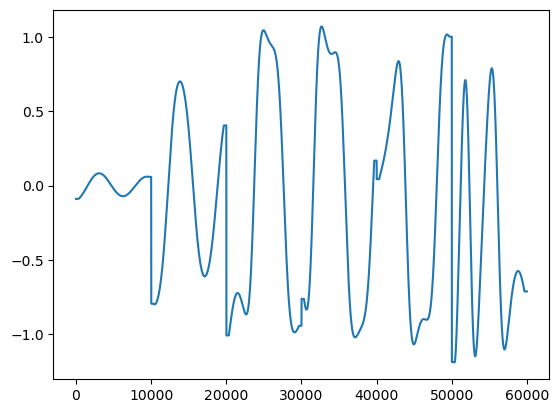

In [ ]:
# data_matrix_df_smooth_appended['d^2(theta) /dt^2'].plot()

In [ ]:
# seq_th_model = sequentialThLin(fit_intercept=True, alpha=0.05, coef_threshold= 0.01)

# seq_th_model.fit(X=refined_candid_lib, y=data_matrix_df_smooth_appended['d(omega) /dt'])
# seq_th_model.score(X=refined_candid_lib, y=data_matrix_df_smooth_appended['d(omega) /dt'])
# # data_matrix_df_smooth_appended["energy"] = 0.5*((data_matrix_df_smooth_appended["x_dot"])**2 + (data_matrix_df_smooth_appended["y_dot"])**2) +  9.81*data_matrix_df_smooth_appended["y"]
# # smoothen_index = abs(data_matrix_df_smooth_appended["energy"]-data_matrix_df_smooth_appended["energy"].mean()) < 0.5*data_matrix_df_smooth_appended["energy"].std()
# # seq_th_model.fit(X=refined_candid_lib[smoothen_index], y=data_matrix_df_smooth_appended[smoothen_index]['d^2(theta) /dt^2'])
# # seq_th_model.score(X=refined_candid_lib[smoothen_index], y=data_matrix_df_smooth_appended[smoothen_index]['d^2(theta) /dt^2'])

Sequential threshold converged in 1 iterations


0.999507310125938

In [ ]:
# dict(zip(seq_th_model.feature_names_in_, seq_th_model.coef_))

{'x': -0.09692327768993957,
 'y': 0.0,
 'theta': 0.0,
 'omega': -0.10069914010326127,
 'x y': 0.0,
 'x theta': 0.0,
 'x omega': 0.0,
 'y^2': 0.0,
 'y theta': 0.0,
 'y omega': 0.0,
 'theta^2': 0.0,
 'theta omega': 0.0,
 'omega^2': 0.0,
 'x y^2': 0.0,
 'x y theta': 0.0,
 'x y omega': 0.0,
 'x theta^2': 0.0,
 'x theta omega': 0.0,
 'x omega^2': 0.0,
 'y^3': 0.0,
 'y^2 theta': 0.0,
 'y^2 omega': 0.0,
 'y theta^2': 0.0,
 'y theta omega': 0.0,
 'y omega^2': 0.0,
 'theta^3': 0.0,
 'theta^2 omega': 0.0,
 'theta omega^2': 0.0,
 'omega^3': 0.0}

In [ ]:
# 

In [ ]:
# 

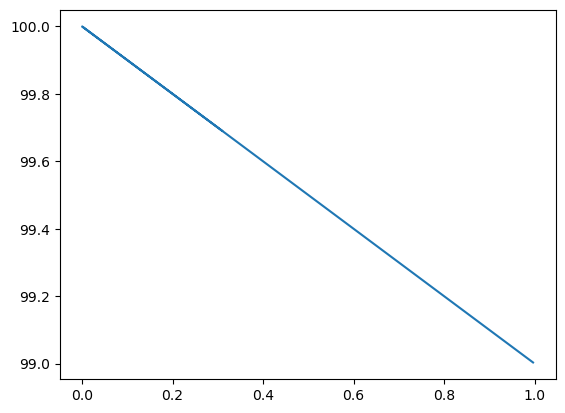

In [ ]:
# plt.plot(candidate_lib_full[:num_time_points]["x^2"], candidate_lib_full[:num_time_points]["y^2"])

In [ ]:
# best_models_full = algebraic_model_th.best_models(1)


# intercept_dictionary = algebraic_model_th.get_fitted_intercepts()

# simplified_equations = get_simplified_equation_list(best_model_df=best_models_full.fillna(0)[:-1],
#                             coef_threshold=0.05,
#                             intercept_threshold= 0.01,
#                              global_feature_list=data_matrix_df_smooth.columns,
#                              intercept_dict= intercept_dictionary,
#                              simplified = True)

NameError: name 'theta' is not defined

In [ ]:

# reduced_relationship_features = construct_reduced_fit_list(candidate_lib_full.columns, simplified_eqs=simplified_equations)

# reduced_relationship_features
# best_relationship = reduced_relationship_features[0]
# if None in best_relationship:
#     best_relationship.remove(None)

# best_relationship_set = set(best_relationship)

***Warning: exception occured while trying to find the monomials of 1:  Cannot initialize from 'dict' without generators
***Warning: exception occured while trying to find the monomials of 0:  Cannot initialize from 'dict' without generators


In [ ]:
# simplified_equations

{'x_dot': {'lhs': 1, 'rhs': 0}}

In [ ]:
# best_relationship_set

{'x x_dot', 'y y_dot'}

In [ ]:
# true_relationship_dict_2degree = {
#     1: {'y^2', 'x^2'},
#     2: {'y', 'x_dot^2', 'y_dot^2'}
# }

# relationship_refinement_2degree = {
#     1: {'x^2','x*x_dot'},
#     2: {'x_dot^2'}
# }

In [ ]:
# discovered_true = False
# relationship_index = None

# for key_,value_ in true_relationship_dict_2degree.items():
#     if best_relationship_set == value_:
#         discovered_true = True
#         relationship_index = key_
# if not discovered_true:
#     wrong_relation_dict[noise_perc].append(simplified_equations)

# features_to_remove =[sympy.sympify(feature) for feature in relationship_refinement_2degree[relationship_index]]

# features_to_remove, refined_candid_lib = get_refined_lib(features_to_remove, data_matrix_df_smooth,
#                                                   candidate_lib_full, get_dropped_feat=True)

# seq_th_model = sequentialThLin(fit_intercept=True, alpha=0.3, coef_threshold= 0.05)
# algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob= seq_th_model)
# algebraic_model_th.fit(refined_candid_lib, scale_columns= True)


# best_models_full = algebraic_model_th.best_models(1)


# intercept_dictionary = algebraic_model_th.get_fitted_intercepts()

# simplified_equations = get_simplified_equation_list(best_model_df=best_models_full.fillna(0)[:-1],
#                             coef_threshold=0.05,
#                             intercept_threshold= 0.01,
#                              global_feature_list=data_matrix_df_smooth.columns,
#                              intercept_dict= intercept_dictionary,
#                              simplified = True)

# reduced_relationship_features = construct_reduced_fit_list(candidate_lib_full.columns, simplified_eqs=simplified_equations)

# reduced_relationship_features
# best_relationship = reduced_relationship_features[0]
# if None in best_relationship:
#     best_relationship.remove(None)

# best_relationship_set = set(best_relationship)

# discovered_second_true = False
# relationship_index = None

# for key_,value_ in true_relationship_dict_2degree.items():
#     if best_relationship_set == value_:
#         discovered_second_true = True
#         relationship_index = key_

# if not discovered_second_true:
#     wrong_relation_dict[noise_perc].append(simplified_equations)


KeyError: None

In [ ]:
# 

In [ ]:
# true_relationship_dict_2degree = {
#     1: {'y^2', 'x^2'},
#     2: {'y', 'x_dot^2', 'y_dot^2'}
# }

# relationship_refinement_2degree = {
#     1: {'x^2','x*x_dot'},
#     2: {'x_dot^2'}
# }
# relationship_index = 1
# features_to_remove =[sympy.sympify(feature) for feature in relationship_refinement_2degree[relationship_index]]

# features_to_remove, refined_candid_lib = get_refined_lib(features_to_remove, data_matrix_df_smooth,
#                                                   candidate_lib_full, get_dropped_feat=True)

# seq_th_model = sequentialThLin(fit_intercept=True, alpha=0.2, coef_threshold= 0.1)
# algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob= seq_th_model)
# algebraic_model_th.fit(refined_candid_lib, scale_columns= True)

Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 1 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 4 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 2 iterations
Sequential threshold converged in 3 iterations
Sequential threshold converged in 2 iterations
Sequential th

AlgModelFinder(custom_model=True,
               custom_model_ob=<dae_finder.sequentialThLin object at 0x129a3fd10>)

In [ ]:
# algebraic_model_th.best_models()

,y_dot,x_dot,y^2 x_dot,x y_dot^2,y_dot^3,x y y_dot,y x_dot,x y_dot,x,y_dot^2,...,y^2 y_dot,y x_dot y_dot,x_dot^3,x_dot^2 y_dot,y y_dot^2,y y_dot,y,y x_dot^2,x y,x_dot^2
x,0.13091809,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,NaN,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
y,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-2.48765925,0.00000000,-4.68896704,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,NaN,0.00000000,0.00000000,0.00000000
x_dot,0.00000000,NaN,16.75963149,0.00000000,0.00000000,-11.11652624,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,41.02955076,0.00000000,12.41547468,0.00000000,0.00000000,-5.65144031,0.00000000,0.00000000
x y,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.09229527,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.66690305,0.00000000,0.00000000,NaN,0.00000000
x y_dot,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.03767614,NaN,0.00000000,1.05193593,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
y^2,0.00000000,0.01702253,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-0.40481194,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-0.12767197,0.00000000,0.00000000,0.00000000
y x_dot,0.00000000,0.04159520,8.98601889,0.00000000,0.00000000,0.00000000,NaN,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,-9.08284652,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-1.21413281
y y_dot,0.03211246,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,4.01563499,0.00000000,0.00000000,0.00000000,0.00000000,NaN,0.00000000,0.00000000,0.24889027,0.00000000
x_dot^2,0.00000000,0.00000000,4.64204052,0.00000000,0.00000000,1.63541469,-0.48947827,0.00000000,0.00000000,-0.39152025,...,0.00000000,0.00000000,0.00000000,-2.79324700,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,NaN
x_dot y_dot,-0.01499745,0.00000000,0.00000000,0.00000000,6.34984978,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,2.59097258,0.00000000,0.00000000,0.00000000,0.00000000,-0.32896641,0.00000000,0.00000000,-0.31218419,-0.11653622


In [ ]:
# best_models_full = algebraic_model_th.best_models(1)


# intercept_dictionary = algebraic_model_th.get_fitted_intercepts()

# simplified_equations = get_simplified_equation_list(best_model_df=best_models_full.fillna(0)[:-1],
#                             coef_threshold=0.001,
#                             intercept_threshold= 0.01,
#                              global_feature_list=data_matrix_df_smooth.columns,
#                              intercept_dict= intercept_dictionary,
#                              simplified = True)

# reduced_relationship_features = construct_reduced_fit_list(candidate_lib_full.columns, simplified_eqs=simplified_equations)

# reduced_relationship_features
# best_relationship = reduced_relationship_features[0]
# if None in best_relationship:
#     best_relationship.remove(None)

# best_relationship_set = set(best_relationship)

In [ ]:
# best_relationship

['x x_dot', 'y y_dot']

In [ ]:
# model_lin = LinearRegression(fit_intercept= True)

# model_lin.fit(X=candidate_lib_full[best_relationship[1:]], y=candidate_lib_full[best_relationship[0]])
# model_lin.score(X=candidate_lib_full[best_relationship[1:]], y=candidate_lib_full[best_relationship[0]])

NameError: name 'best_relationship' is not defined

In [ ]:
# dict(zip(model_lin.feature_names_in_, model_lin.coef_))

{'y y_dot': -1.0000000000000002}

In [ ]:
# 

In [ ]:
# #Use lasso model by default
# algebraic_model_1 = AlgModelFinder(model_id='lasso', alpha=0.3, fit_intercept=True)
# algebraic_model_1.fit(candidate_lib_full, scale_columns= True)


# algebraic_model_1.best_models(5)

,x y,y y_dot,x x_dot,x,x_dot
x,0.00000000,0.00000000,-0.00000000,NaN,0.00000000
y,0.00000000,-0.00000000,-0.00000000,-0.00000000,0.00000000
x_dot,0.00000000,-0.00000000,0.00000000,0.00000000,NaN
y_dot,0.00000000,-0.00000000,0.00000000,-0.00000000,-0.00000000
x^2,-0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
x x_dot,0.00000000,-0.16819653,NaN,-0.00000000,0.00000000
x y_dot,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
y^2,-0.00000000,-0.00000000,-0.00000000,-0.00000000,-0.00000000
y x_dot,-0.00000000,-0.00000000,0.00000000,-0.00000000,-0.00000000
y y_dot,-0.00000000,NaN,-0.25102333,0.00000000,-0.00000000


In [ ]:
# 

In [ ]:
# features_to_remove = {x**2}

# features_to_remove, refined_candid_lib = get_refined_lib(features_to_remove, data_matrix_df_new,
#                                                   candidate_lib_full, get_dropped_feat=True)

In [ ]:
# seq_th_model = sequentialThLin(fit_intercept=True, alpha=0.05, coef_threshold= 0.01)

# seq_th_model.fit(X=refined_candid_lib, y=data_matrix_df_smooth_appended['d(omega) /dt'])
# seq_th_model.score(X=refined_candid_lib, y=data_matrix_df_smooth_appended['d(omega) /dt'])

Sequential threshold converged in 2 iterations


0.9957152953778207

In [ ]:
# dict(zip(seq_th_model.feature_names_in_, seq_th_model.coef_))

{'x': -0.09573934924860023,
 'y': 0.0,
 'theta': 0.0,
 'omega': 0.0,
 'x y': 0.0,
 'x theta': 0.0,
 'x omega': 0.0,
 'y^2': 0.0,
 'y theta': 0.0,
 'y omega': 0.0,
 'theta^2': 0.0,
 'theta omega': 0.0,
 'omega^2': 0.0,
 'x y^2': 0.0,
 'x y theta': 0.0,
 'x y omega': 0.0,
 'x theta^2': 0.0,
 'x theta omega': 0.0,
 'x omega^2': 0.0,
 'y^3': 0.0,
 'y^2 theta': 0.0,
 'y^2 omega': 0.0,
 'y theta^2': 0.0,
 'y theta omega': 0.0,
 'y omega^2': 0.0,
 'theta^3': 0.0,
 'theta^2 omega': 0.0,
 'theta omega^2': 0.0,
 'omega^3': 0.0}

In [ ]:
# 

In [ ]:
# 

In [ ]:
# model_lin.intercept_

3.552713678800501e-15

In [ ]:
# data_matrix_df_smooth_appended.columns

Index(['t', 'x', 'd(x) /dt', 'd^2(x) /dt^2', 'y', 'd(y) /dt', 'd^2(y) /dt^2',
       'theta', 'd(theta) /dt', 'd^2(theta) /dt^2', 'omega', 'd(omega) /dt',
       'd^2(omega) /dt^2'],
      dtype='object')

# FInal param est

In [ ]:

# model_lin = LinearRegression(fit_intercept= True)

# model_lin.fit(X=candidate_lib_full[["x_dot^2", "y_dot^2", "y^2"]], y=candidate_lib_full["y"])
# model_lin.score(X=candidate_lib_full[["x_dot^2", "y_dot^2", "y^2"]], y=candidate_lib_full["y"])

0.9918091633484667

In [ ]:
# dict(zip(model_lin.feature_names_in_, model_lin.coef_))

{'x_dot^2': -0.051864451499145,
 'y_dot^2': -0.05106337810338052,
 'y^2': 0.002454517776341498}

In [ ]:
# 

In [ ]:
# 

In [ ]:

# model_lin = LinearRegression(fit_intercept= True)

# model_lin.fit(X=candidate_lib_full[["x_dot^2",  "y"]], y=candidate_lib_full["y_dot^2"])
# model_lin.score(X=candidate_lib_full[["x_dot^2", "y"]], y=candidate_lib_full["y_dot^2"])

0.9978909782993777

In [ ]:
# dict(zip(model_lin.feature_names_in_, model_lin.coef_))

{'x_dot^2': -1.0618209114865043, 'y': -19.52140809693293}

In [ ]:
# 

In [ ]:
# 

In [ ]:
# model_lin = LinearRegression(fit_intercept= True)

# model_lin.fit(X=candidate_lib_full[["x_dot^2", "y_dot^2", "y^2", "x_dot y_dot"]], y=candidate_lib_full["y"])
# model_lin.score(X=candidate_lib_full[["x_dot^2", "y_dot^2", "y^2", "x_dot y_dot"]], y=candidate_lib_full["y"])

0.9999068525947747

In [ ]:
# dict(zip(model_lin.feature_names_in_, model_lin.coef_))

{'x_dot^2': -0.05104276845691093,
 'y_dot^2': -0.0510480714267504,
 'y^2': -6.73522336734388e-05,
 'x_dot y_dot': -2.1570969168485095e-05}

In [ ]:
# 

In [ ]:
# model_lin.intercept_

AttributeError: 'LinearRegression' object has no attribute 'intercept_'

In [ ]:
# # Expected coefficient of x_dot^2 and y_dot^2 
# 1/(9.8*2) #1/2 * 1/g

0.0510204081632653

In [ ]:
# # Expected intercept (coming from energy)
# L #L

5.0

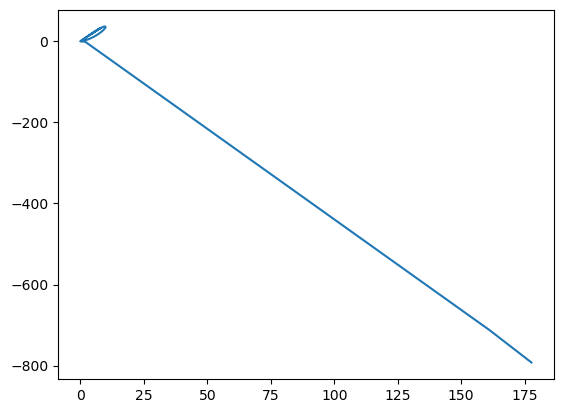

In [ ]:
# plt.plot(candidate_lib_full["x_dot^2"][:50], candidate_lib_full["y x_dot^2"][:50])

In [ ]:
# plt.plot(candidate_lib_full["y^3"][:100000], candidate_lib_full["x_dot^2"][:100000])

KeyError: 'y^3'

In [ ]:
# 

In [ ]:
# model_lin = LinearRegression(fit_intercept= True)

# model_lin.fit(X=candidate_lib_full[["y^2", "d(y) /dt^2"]], y=candidate_lib_full["x^2"])

In [ ]:
# 

### SVD analysis

In [ ]:
# pca_1 = decomposition.PCA()
# pca_1.fit(candidate_lib_full)


# pca_2 = decomposition.PCA()
# pca_2.fit(candidate_lib_full.drop(["x^2", "x x_dot"],axis=1))

# pca_3 = decomposition.PCA()
# pca_3.fit(candidate_lib_full.drop(["x^2", "x x_dot", "y"],axis=1))


# var_expl_ratio = pca_1.explained_variance_ratio_
# theta_dot_sq_rem_expl_ratio = pca_2.explained_variance_ratio_
# theta_dot_rem_expl_ratio = pca_3.explained_variance_ratio_


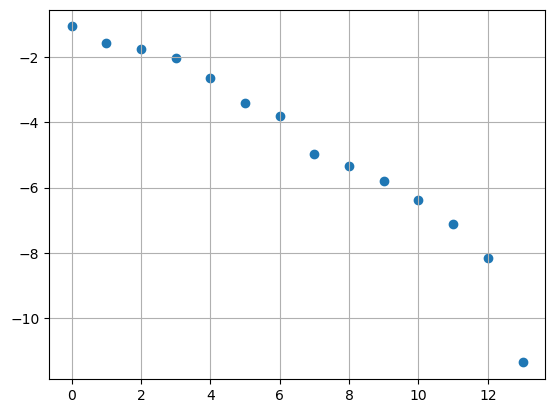

In [ ]:

# plt.scatter(np.arange(len(var_expl_ratio)),np.log(var_expl_ratio))
# plt.grid()
# # for x, y in zip(np.arange(len(candid_lib_sing_values)),np.log(candid_lib_sing_values)):
# #     plt.text(x,y,y)

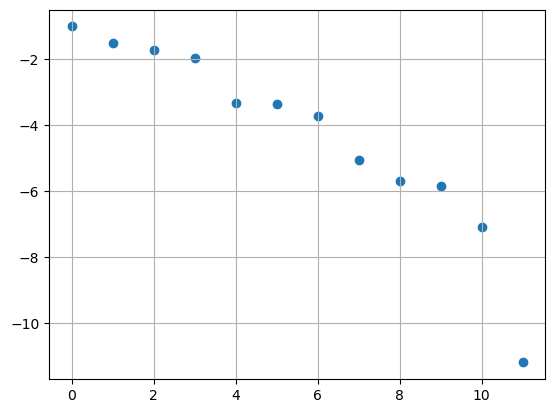

In [ ]:

# plt.scatter(np.arange(len(theta_dot_sq_rem_expl_ratio)),np.log(theta_dot_sq_rem_expl_ratio))
# plt.grid()
# # for x, y in zip(np.arange(len(candid_lib_sing_values)),np.log(candid_lib_sing_values)):
# #     plt.text(x,y,y)

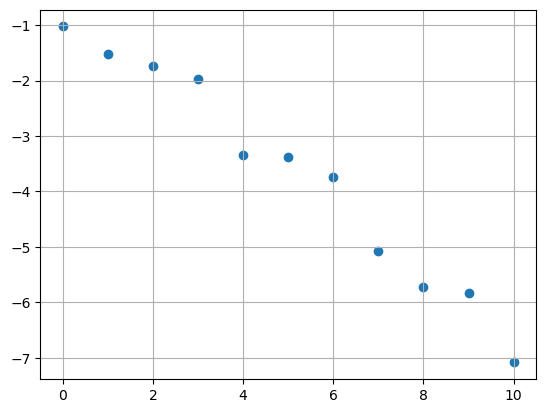

In [ ]:

# plt.scatter(np.arange(len(theta_dot_rem_expl_ratio)),np.log(theta_dot_rem_expl_ratio))
# plt.grid()
# # for x, y in zip(np.arange(len(candid_lib_sing_values)),np.log(candid_lib_sing_values)):
# #     plt.text(x,y,y)

In [ ]:
# !pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 37.0 MB/s eta 0:00:0000:0100:01


In [ ]:
# import cv2

# cap = cv2.VideoCapture("pendulum_1.mp4")

In [ ]:
# fgbg = cv2.createBackgroundSubtractorMOG2()

In [ ]:
# while cap.isOpened():
#     ret, frame = cap.read()
#     if not ret:
#         break

#     # Convert to grayscale for processing
#     gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#     blurred = cv2.GaussianBlur(gray, (5, 5), 0)

#     # Apply edge detection
#     edges = cv2.Canny(blurred, 50, 150)

#     # Find contours of detected objects
#     contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
#     for contour in contours:
#         if cv2.contourArea(contour) > 100:  # Filter small noise
#             (x, y), radius = cv2.minEnclosingCircle(contour)
#             center = (int(x), int(y))
#             radius = int(radius)
            
#             if radius > 5:  # Ensure it's large enough to be the pendulum
#                 cv2.circle(frame, center, radius, (0, 255, 0), 2)

#     cv2.imshow("Pendulum Tracking", frame)
#     if cv2.waitKey(30) & 0xFF == ord('q'):
#         break

# cap.release()
# cv2.destroyAllWindows()

KeyboardInterrupt: 

# Pendulum video footage 

In [ ]:
import cv2
import numpy as np

def pick_color(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:  # Left mouse click
        pixel = frame[y, x]
        hsv_pixel = cv2.cvtColor(np.uint8([[pixel]]), cv2.COLOR_BGR2HSV)[0][0]
        print(f"HSV Color at ({x}, {y}): {hsv_pixel}")
ind = 3
video_path = "pendulum_damped_{}.mov".format(ind)
cap = cv2.VideoCapture(video_path)

cv2.namedWindow("Frame")
cv2.setMouseCallback("Frame", pick_color)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    cv2.imshow("Frame", frame)
    if cv2.waitKey(30) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


HSV Color at (947, 720): [  0   0 112]


In [ ]:
# center = (943.5, 711.5)
center = (947, 720)
color = [120, 255, 243]

In [595]:
import cv2
import numpy as np
import pandas as pd

# Define HSV color range for the pendulum bob (Replace with detected values)
lower_color = np.array([120, 255, 243])  # Replace with detected values
upper_color = np.array([120, 255, 243])

for ind in [5,6,7,8,9]:
    # ind =1
    video_path = "pendulum_damped_{}.mov".format(ind)

    cap = cv2.VideoCapture(video_path)

    # Get FPS (frames per second) from video
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_time = 1 / fps  # Time interval between frames

    # List to store detected coordinates with time
    positions = []
    frame_count = 0  # To track frame number

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_count += 1  # Track frame number
        time = frame_count * frame_time  # Compute time in seconds

        # Convert frame to HSV
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

        # Create a mask for the pendulum bob's color
        mask = cv2.inRange(hsv, lower_color, upper_color)

        # Perform morphological operations
        kernel = np.ones((5, 5), np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

        # Find contours from the mask
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if contours:
            # Select the largest contour (assumed to be the pendulum bob)
            largest_contour = max(contours, key=cv2.contourArea)

            # Get bounding box around the detected bob
            x, y, w, h = cv2.boundingRect(largest_contour)

            # Calculate center of the bounding box (Pendulum bob's position)
            center_x = x + w // 2
            center_y = y + h // 2

            # Store time and coordinates
            positions.append([time, center_x, center_y])

            # Draw tracking marker
            cv2.circle(frame, (center_x, center_y), 5, (0, 255, 0), -1)
            cv2.putText(frame, f"({center_x}, {center_y})", (center_x + 10, center_y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

        # Show the tracking result
        cv2.imshow("Pendulum Tracking", frame)

        if cv2.waitKey(30) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

    # Convert positions to a DataFrame and save as CSV
    df = pd.DataFrame(positions, columns=["t", "X", "Y"])
    df.to_csv("pendulum_time_series_damped_{}.csv".format(ind), index=False)

    print("Pendulum position data with time saved to 'pendulum_time_series.csv'")


Pendulum position data with time saved to 'pendulum_time_series.csv'
Pendulum position data with time saved to 'pendulum_time_series.csv'
Pendulum position data with time saved to 'pendulum_time_series.csv'
Pendulum position data with time saved to 'pendulum_time_series.csv'
Pendulum position data with time saved to 'pendulum_time_series.csv'


## Loading data

In [575]:
# Loading pendulum data
df_list = []
for ind in [1,3,4]:
    file_path = f"pendulum_time_series_damped_{ind}.csv"
    df = pd.read_csv(file_path)
    df_list.append(df)

# trimming_slices=  [(50,1400), (50,1200), (400,1400)]
trimming_slices=  [(50,3000), (50,3000), (50,3000)]

df_trimmed = []
for df_, slice in zip(df_list, trimming_slices):
    df_trimmed.append(df_[slice[0]:slice[1]].reset_index(drop=True))

#centering the hook of pendulum to origin
center = (947, 720)
color = [120, 255, 243]
for df_ in df_trimmed:
    df_["x"] = df_["X"] - center[0]
    df_["y"] = df_["Y"] - center[1]

for i, df in enumerate(df_trimmed):
    df.to_csv(f"trimmed_pendulum_time_series_damped_{i+1}.csv", index=False)

In [576]:
L=1    
smoothening_window_size = 15
pen_orig_len = abs(df_trimmed[0]["y"].max())
#Scaling the pendulum length to L
for df_ in df_trimmed:
    df_["x"] = (df_["x"]/pen_orig_len) * L
    df_["y"] = (df_["y"]/pen_orig_len) * L

    # df_["x"] = df_["x"].rolling(window=smoothening_window_size, center=True).mean()
    # df_["y"] = df_["y"].rolling(window=smoothening_window_size, center=True).mean()

    # df_["theta"] = np.arctan2(df_["y"], df_["x"])
    df_["theta"] = (np.arctan2(df_["y"], df_["x"])).rolling(window=smoothening_window_size, center=True).mean()
    df_.dropna(ignore_index=True, inplace=True)




In [577]:
df_trimmed[0]

,t,X,Y,x,y,theta
0,0.96749288,1328,1000,0.80210526,0.58947368,0.64985165
1,0.98417379,1341,984,0.82947368,0.55578947,0.60286705
2,1.00085470,1361,956,0.87157895,0.49684211,0.55796985
3,1.01753561,1362,948,0.87368421,0.48000000,0.51746958
4,1.03421652,1370,932,0.89052632,0.44631579,0.48009675
...,...,...,...,...,...,...
2269,38.81648148,1012,1188,0.13684211,0.98526316,1.43350199
2270,38.83316239,1008,1188,0.12842105,0.98526316,1.44045306
2271,38.84984330,1007,1188,0.12631579,0.98526316,1.44839016
2272,38.86652422,1002,1188,0.11578947,0.98526316,1.45718315


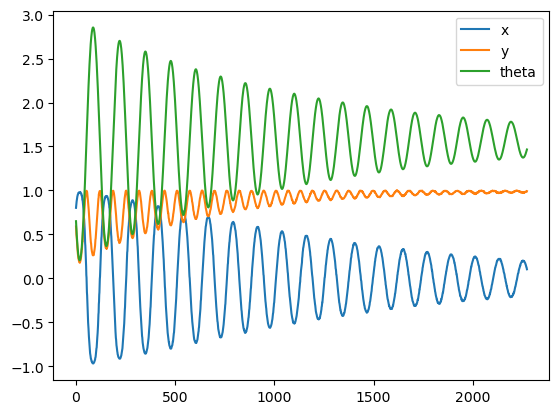

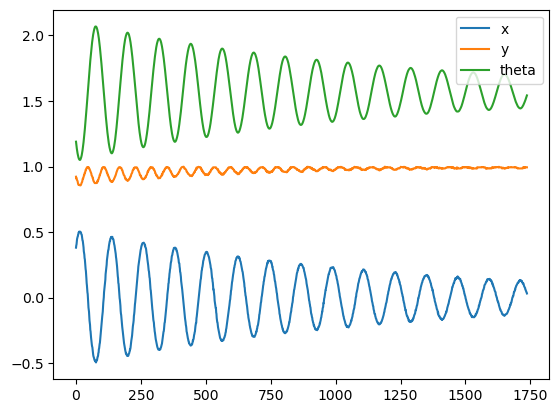

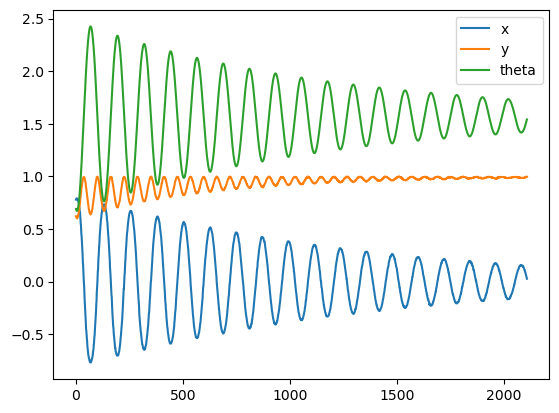

In [578]:
for df_ in df_trimmed:
    df_[["x", "y", "theta"]].plot()

In [579]:
df_appended = pd.concat(df_trimmed, ignore_index=True)

In [580]:
# df["x"] = df["X"] - 614
# df["y"] = df["Y"] - 555


# # HSV Color at (614, 555): [  0   0 117]
# # HSV Color at (615, 552): [  0   0 120]

In [581]:
# df["x"] = df["x"]/abs(df["y"].max())*10
# df["y"] = df["y"]/abs(df["y"].max())*10


In [582]:
# df[["x","y","t"]][300:600].plot()

In [583]:
(df_appended["x"]**2+df_appended["y"]**2).std()

# (df_appended["x"]**2+df_appended["y"]**2).mean()

0.005130468850104456

<Axes: >

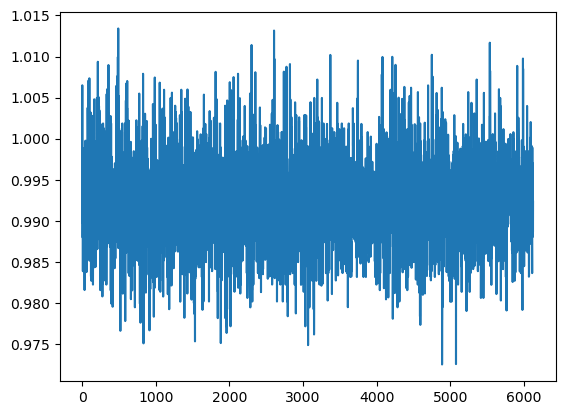

In [584]:
(df_appended["x"]**2+df_appended["y"]**2).plot()

In [585]:
# df_new = df[["x","y","t"]][300:600].reset_index(drop=True)
# df_new["theta"] = np.arctan2(df_new["y"], df_new["x"])
# from copy import deepcopy
# data_matrix_df_smooth_appended = smooth_data(df_new,
#                 domain_var="t",
#                 smooth_method ="SG",
#                 noise_perc=2,
#                 derr_order=2,
#                 polyorder=2,
#                 window_smooth=None)

In [586]:
# df_new[["x","y"]]

In [587]:
import os, sys

path_to_add = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.append(path_to_add)
print(os.path.join(path_to_add, "daeFinder"))
sys.path.append(os.path.join(path_to_add, "daeFinder"))
from daeFinder import smooth_data


/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder


In [588]:
data_amplify_fact = 1
# num_smoothed_points = num_time_points*data_amplify_fact

# t_eval_new = np.linspace(data_matrix_df_list[0]["t"].iloc[0], data_matrix_df_list[0]["t"].iloc[-1], num_smoothed_points)

#Calling the smoothening function
# data_matrix_smooth_df_list = [smooth_data(data_matrix,derr_order=2, noise_perc=0.05, s_param_=0.5) for data_matrix in df_trimmed]
data_matrix_smooth_df_list = [
    smooth_data(data_matrix,
                domain_var="t",
                smooth_method ="SG",
                noise_perc=0.1,
                derr_order=2,
                polyorder=2,
                window_smooth=None)[100:-100]
    for data_matrix in df_trimmed]



# data_matrix_df["d(x) /dt"] = -data_matrix_df['y']*data_matrix_df['omega']
# data_matrix_df["d(y) /dt"] = data_matrix_df['x']*data_matrix_df['omega']
# # data_matrix_df_new = data_matrix_df[["x","y", "d(x) /dt", "d(y) /dt"]]
# data_matrix_df_new = data_matrix_df_smooth_appended[["x","y", "theta", "d(theta) /dt"]]
# data_matrix_df_new = data_matrix_df_smooth_appended[["x","y"]]
# data_matrix_smooth_df_list = [
#     smooth_data(data_matrix,
#                 domain_var="t",
#                 smooth_method ="SG",
#                 noise_perc=0.05,
#                 derr_order=2,
#                 polyorder=2,
#                 window_smooth=None)[100:400]
#     for data_matrix in df_trimmed]


if len(data_matrix_smooth_df_list) == 1:
    data_matrix_df_smooth_appended = data_matrix_smooth_df_list[0].reset_index(drop=True)
else:
    data_matrix_df_smooth_appended = pd.concat(data_matrix_smooth_df_list, ignore_index=True)

# data_matrix_df_new = pd.concat([df_[100:-100] for df_ in df_trimmed], ignore_index=True)[["x","y", "theta"]]
# data_matrix_df_new["d(theta) /dt"] = data_matrix_df_smooth_appended["d(theta) /dt"]
# 
# data_matrix_df_new = df_appended[["x","y", "theta"]]
# data_matrix_df_new= data_matrix_df_smooth_appended[["x","y", "theta", "d(theta) /dt"]]
data_matrix_df_new= data_matrix_df_smooth_appended[["theta", "d(theta) /dt"]]




# data_matrix_df_new = data_matrix_df_new.rename(columns= dict(zip(data_matrix_df_new, ['x', 'y', 'theta', 'theta_dot'])))
data_matrix_df_new = data_matrix_df_new.rename(columns= dict(zip(data_matrix_df_new, ['theta', 'theta_dot'])))

In [589]:
data_matrix_df_smooth_appended.columns

Index(['t', 'X', 'd(X) /dt', 'd^2(X) /dt^2', 'Y', 'd(Y) /dt', 'd^2(Y) /dt^2',
       'x', 'd(x) /dt', 'd^2(x) /dt^2', 'y', 'd(y) /dt', 'd^2(y) /dt^2',
       'theta', 'd(theta) /dt', 'd^2(theta) /dt^2'],
      dtype='object')

In [590]:
import os, sys

path_to_add = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.append(path_to_add)
print(os.path.join(path_to_add, "daeFinder"))
sys.path.append(os.path.join(path_to_add, "daeFinder"))

poly_degree = 2
from daeFinder import PolyFeatureMatrix
poly_feature_ob = PolyFeatureMatrix(poly_degree)
candidate_lib_full = poly_feature_ob.fit_transform(data_matrix_df_new)
# candidate_lib_full = poly_feature_ob.fit_transform(data_matrix_df_smooth)





candidate_lib_full = candidate_lib_full.drop(["1"], axis=1)
print("Degree of library: {}".format(poly_degree))
print("# terms in the library: {}".format(candidate_lib_full.shape[1]))

#Optionally removing features from the library
terms_to_drop_corr = set()
candidate_lib_full = candidate_lib_full.drop(terms_to_drop_corr, axis=1)
print("Full candidate library has the following features: {}".format(candidate_lib_full.columns))


/Users/manujayadharan/git_repos/DAE-FINDER_dev/daeFinder
Degree of library: 2
# terms in the library: 5
Full candidate library has the following features: Index(['theta', 'theta_dot', 'theta^2', 'theta theta_dot', 'theta_dot^2'], dtype='object')


In [591]:
# candidate_lib_full["sin(theta)"] = np.sin(candidate_lib_full["theta"])
# candidate_lib_full["cos(theta)"] = np.cos(candidate_lib_full["theta"])
candidate_lib_full["x"] = data_matrix_df_smooth_appended["x"]
candidate_lib_full["y"] = data_matrix_df_smooth_appended["y"]

# candidate_lib_full["x"] = df_trimmed[0][100:-100]["x"].reset_index(drop=True)
# candidate_lib_full["y"] = df_trimmed[0][100:-100]["y"].reset_index(drop=True)


In [279]:
from daeFinder import sequentialThLin
from daeFinder import AlgModelFinder
from daeFinder import remove_paranth_from_feat
# Adding the state variables as scipy symbols
# feat_list = list(data_matrix_df_smooth_appended.columns)
feat_list = ["x","y", "theta", "theta_dot"]
feat_list_str = ", ".join(remove_paranth_from_feat(feat_list))
exec(feat_list_str+ "= sympy.symbols("+str(feat_list)+")")




seq_th_model = sequentialThLin(fit_intercept=True, alpha=0.2, coef_threshold= 0.1)
# seq_th_model = sequentialThLin(model_id="LR", coef_threshold= 0.1)

algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob= seq_th_model)

algebraic_model_th.fit(candidate_lib_full, scale_columns= False)

algebraic_model_th.best_models()

ValueError: Input X contains NaN.
Ridge does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [280]:
# candidate_lib_full[]

In [281]:
features_to_remove = {x**2}

features_to_remove, refined_candid_lib = get_refined_lib(features_to_remove, data_matrix_df_new,
                                                  candidate_lib_full, get_dropped_feat=True)

NameError: name 'x' is not defined

In [282]:
refined_candid_lib.columns

NameError: name 'refined_candid_lib' is not defined

In [283]:
df_trimmed[0]

,t,X,Y,x,y,theta
0,0.85072650,1190,1127,0.51265823,0.85864979,1.03254759
1,0.86740741,1215,1107,0.56540084,0.81645570,0.96511731
2,0.88408832,1249,1084,0.63713080,0.76793249,0.87822372
3,0.90076923,1271,1064,0.68354430,0.72573840,0.81532934
4,0.91745014,1282,1054,0.70675105,0.70464135,0.78390340
...,...,...,...,...,...,...
1345,23.28655271,757,1153,-0.40084388,0.91350211,1.98429662
1346,23.30323362,753,1150,-0.40928270,0.90717300,1.99461681
1347,23.31991453,750,1150,-0.41561181,0.90717300,2.00039844
1348,23.33659544,747,1149,-0.42194093,0.90506329,2.00704059


<Axes: >

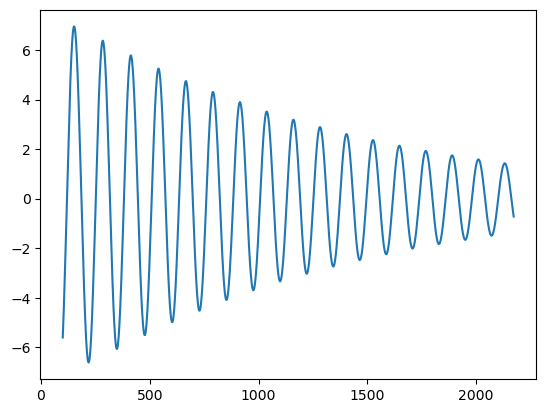

In [490]:
data_matrix_smooth_df_list[0]['d^2(theta) /dt^2'].plot()

In [491]:
# seq_th_model = sequentialThLin(fit_intercept=True, alpha=0.05, coef_threshold= 0.01)

# seq_th_model.fit(X=refined_candid_lib, y=data_matrix_df_smooth_appended['d(omega) /dt'])
# seq_th_model.score(X=refined_candid_lib, y=data_matrix_df_smooth_appended['d(omega) /dt'])
# # data_matrix_df_smooth_appended["energy"] = 0.5*((data_matrix_df_smooth_appended["x_dot"])**2 + (data_matrix_df_smooth_appended["y_dot"])**2) +  9.81*data_matrix_df_smooth_appended["y"]
# # smoothen_index = abs(data_matrix_df_smooth_appended["energy"]-data_matrix_df_smooth_appended["energy"].mean()) < 0.5*data_matrix_df_smooth_appended["energy"].std()
# # seq_th_model.fit(X=refined_candid_lib[smoothen_index], y=data_matrix_df_smooth_appended[smoothen_index]['d^2(theta) /dt^2'])
# # seq_th_model.score(X=refined_candid_lib[smoothen_index], y=data_matrix_df_smooth_appended[smoothen_index]['d^2(theta) /dt^2'])

In [186]:
data_matrix_df_smooth_appended.columns

Index(['t', 'X', 'd(X) /dt', 'd^2(X) /dt^2', 'Y', 'd(Y) /dt', 'd^2(Y) /dt^2',
       'x', 'd(x) /dt', 'd^2(x) /dt^2', 'y', 'd(y) /dt', 'd^2(y) /dt^2',
       'theta', 'd(theta) /dt', 'd^2(theta) /dt^2'],
      dtype='object')

In [404]:
seq_th_model = sequentialThLin(model_id="lasso" ,fit_intercept=True, alpha=0.3, coef_threshold= 0.3)
# seq_th_model = sequentialThLin(fit_intercept=True, model_id="LR", coef_threshold= 0.05)

down_size = 100
X_downsampled = refined_candid_lib.iloc[::down_size, :].reset_index(drop=True)
y_downsampled = data_matrix_df_smooth_appended['d^2(theta) /dt^2'].iloc[::down_size].reset_index(drop=True)

seq_th_model.fit(X=X_downsampled, y=y_downsampled)
seq_th_model.score(X=X_downsampled, y=y_downsampled)
# data_matrix_df_smooth_appended["energy"] = 0.5*((data_matrix_df_smooth_appended["x_dot"])**2 + (data_matrix_df_smooth_appended["y_dot"])**2) +  9.81*data_matrix_df_smooth_appended["y"]
# smoothen_index = abs(data_matrix_df_smooth_appended["energy"]-data_matrix_df_smooth_appended["energy"].mean()) < 0.5*data_matrix_df_smooth_appended["energy"].std()
# seq_th_model.fit(X=refined_candid_lib[smoothen_index], y=data_matrix_df_smooth_appended[smoothen_index]['d^2(theta) /dt^2'])
# seq_th_model.score(X=refined_candid_lib[smoothen_index], y=data_matrix_df_smooth_appended[smoothen_index]['d^2(theta) /dt^2'])

NameError: name 'refined_candid_lib' is not defined

In [592]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler with mean=False to keep the mean the same
scaler = StandardScaler(with_std=True, with_mean=False)

# Scale candidate_lib_full
candidate_lib_full_scaled = pd.DataFrame(scaler.fit_transform(candidate_lib_full), columns=candidate_lib_full.columns)

# Scale data_matrix_df_smooth_appended
data_matrix_df_smooth_appended_scaled = pd.DataFrame(scaler.fit_transform(data_matrix_df_smooth_appended), columns=data_matrix_df_smooth_appended.columns)



In [593]:
seq_th_model = sequentialThLin(model_id="lasso" ,fit_intercept=True, alpha=0.002, coef_threshold= 0.01)
# seq_th_model = sequentialThLin(model_id="lasso" ,fit_intercept=True, alpha=0.001, coef_threshold= 0.01)

# seq_th_model = sequentialThLin(fit_intercept=True, model_id="LR", coef_threshold= 0.05)

down_size = 100
X_downsampled = candidate_lib_full_scaled.iloc[::down_size, :].reset_index(drop=True)
y_downsampled = data_matrix_df_smooth_appended_scaled['d^2(theta) /dt^2'].iloc[::down_size].reset_index(drop=True)

seq_th_model.fit(X=X_downsampled, y=y_downsampled)
seq_th_model.score(X=X_downsampled, y=y_downsampled)
# data_matrix_df_smooth_appended["energy"] = 0.5*((data_matrix_df_smooth_appended["x_dot"])**2 + (data_matrix_df_smooth_appended["y_dot"])**2) +  9.81*data_matrix_df_smooth_appended["y"]
# smoothen_index = abs(data_matrix_df_smooth_appended["energy"]-data_matrix_df_smooth_appended["energy"].mean()) < 0.5*data_matrix_df_smooth_appended["energy"].std()
# seq_th_model.fit(X=refined_candid_lib[smoothen_index], y=data_matrix_df_smooth_appended[smoothen_index]['d^2(theta) /dt^2'])

# seq_th_model.score(X=refined_candid_lib[smoothen_index], y=data_matrix_df_smooth_appended[smoothen_index]['d^2(theta) /dt^2'])

Sequential threshold converged in 1 iterations


0.996406268389636

In [594]:
dict(zip(seq_th_model.feature_names_in_, seq_th_model.coef_))

{'theta': 0.0,
 'theta_dot': -0.018719030774661086,
 'theta^2': 0.0,
 'theta theta_dot': 0.0,
 'theta_dot^2': 0.0,
 'x': 0.9950095365865163,
 'y': 0.0}

In [457]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression(fit_intercept=True)
lin_model.fit(X=refined_candid_lib[["x", "theta_dot"]], y=data_matrix_df_smooth_appended['d^2(theta) /dt^2'])
lin_model.score(X=refined_candid_lib[["x", "theta_dot"]], y=data_matrix_df_smooth_appended['d^2(theta) /dt^2'])



NameError: name 'refined_candid_lib' is not defined

In [458]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression(fit_intercept=True)
lin_model.fit(X=candidate_lib_full[["x", "theta", "theta_dot"]], y=data_matrix_df_smooth_appended['d^2(theta) /dt^2'])
lin_model.score(X=candidate_lib_full[["x","theta", "theta_dot"]], y=data_matrix_df_smooth_appended['d^2(theta) /dt^2'])



0.7580623533741149

In [459]:
dict(zip(lin_model.feature_names_in_, lin_model.coef_))

{'x': -6.598780978342362,
 'theta': -13.565133231856823,
 'theta_dot': -0.8563139537421124}

In [525]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression(fit_intercept=True)
lin_model.fit(X=X_downsampled[["x", "theta", "theta_dot"]], y=y_downsampled)
lin_model.score(X=X_downsampled[["x","theta", "theta_dot"]], y=y_downsampled)

0.9967374988731666

In [526]:
dict(zip(lin_model.feature_names_in_, lin_model.coef_))

{'x': 6.780773487503746,
 'theta': 1.3253154133785017,
 'theta_dot': -0.0901554295092958}

In [527]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression(fit_intercept=True)
lin_model.fit(X=X_downsampled[["x", "theta_dot"]], y=y_downsampled)
lin_model.score(X=X_downsampled[["x", "theta_dot"]], y=y_downsampled)

0.9964133435724467

In [528]:
dict(zip(lin_model.feature_names_in_, lin_model.coef_))

{'x': 5.366686491093255, 'theta_dot': -0.11371242808791669}

In [29]:
# from sklearn.linear_model import LinearRegression

lin_model = LinearRegression(fit_intercept=True)
lin_model.fit(X=candidate_lib_full[["sin(theta)"]], y=data_matrix_df_smooth_appended['d^2(theta) /dt^2'])
lin_model.score(X=candidate_lib_full[["sin(theta)"]], y=data_matrix_df_smooth_appended['d^2(theta) /dt^2'])

KeyError: "None of [Index(['sin(theta)'], dtype='object')] are in the [columns]"

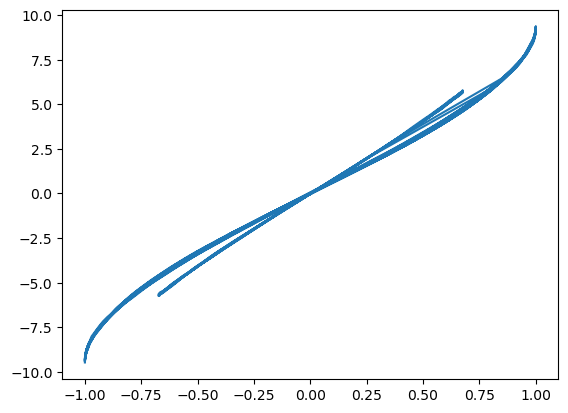

In [ ]:
plt.plot(candidate_lib_full["cos(theta)"], data_matrix_df_smooth_appended['d^2(theta) /dt^2'])

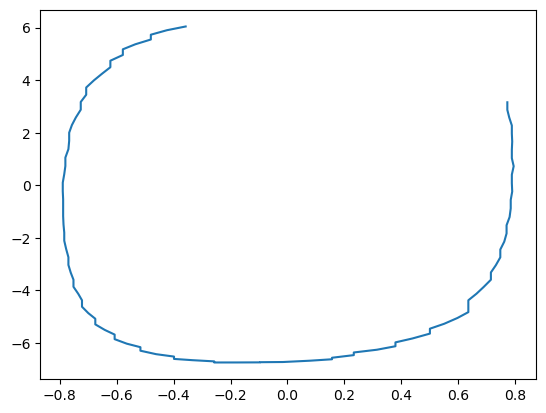

In [1587]:
plt.plot(np.sin(df_trimmed[0]["x"][100:200]), data_matrix_df_smooth_appended['d^2(theta) /dt^2'][100:200])

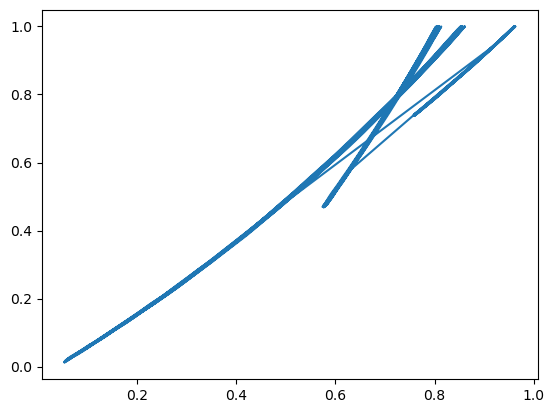

In [1591]:
plt.plot(data_matrix_df_smooth_appended["y"], candidate_lib_full['sin(theta)'])

In [ ]:
window_size = 15
df_trimmed_new_list = deepcopy(df_trimmed)
for df_ in df_trimmed_new_list:
    # Calculate the first derivative of theta
    df_["dt"] = df["t"].diff()  # Time difference between frames
    df_["theta_smooth"] = df_["theta"].rolling(window=window_size, center=True).mean()
    df_['theta_dot'] = df_["theta_smooth"].diff() / df_["dt"]

    # Apply moving average smoothing to velocity (optional)
    df_["theta_dot_smooth"] = df_["theta_dot"].rolling(window=window_size, center=True).mean()
    df_['theta_double_dot'] = df_["theta_dot_smooth"].diff() / df_["dt"]
    df_["theta_double_dot_smooth"] = df_["theta_double_dot"].rolling(window=window_size, center=True).mean()


# Display the updated dataframe
# print(df_appended[['theta', 'theta_dot', 'theta_double_dot']].head(10))
df_trimmed_append = pd.concat([df_[100:500] for df_ in df_trimmed_new_list], ignore_index=True)
# df_append_adjusted =df_appended[abs(df_trimmed_append["theta_double_dot"])<0.1]
# df_append_adjusted = df_append_adjusted[abs(df_append_adjusted["theta_dot"])<0.15]


<Axes: >

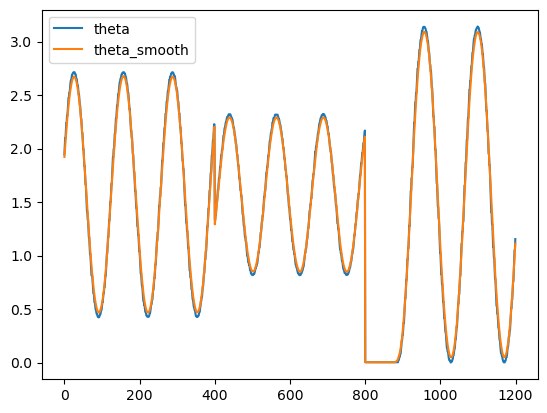

In [534]:
df_trimmed_append[["theta", "theta_smooth"]].plot()

<Axes: >

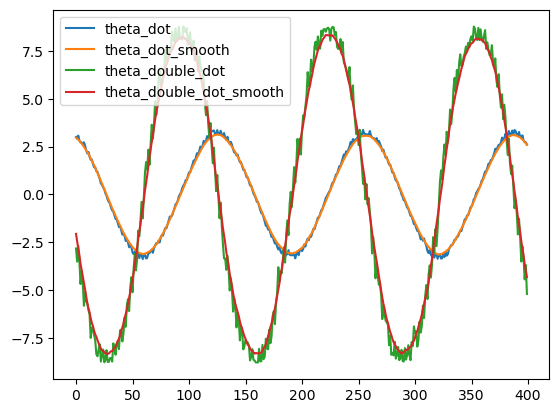

In [535]:
df_trimmed_append[["theta_dot", "theta_dot_smooth", "theta_double_dot", "theta_double_dot_smooth"]][:400].plot()

In [536]:
dict(zip(lin_model.feature_names_in_, lin_model.coef_))

{'x': 7.872292819866226}

In [537]:
# from sklearn.linear_model import LinearRegression

lin_model = LinearRegression(fit_intercept=True)
lin_model.fit(X=df_trimmed_append[["x"]], y=df_trimmed_append['theta_double_dot_smooth'])
lin_model.score(X=df_trimmed_append[["x"]], y=df_trimmed_append['theta_double_dot_smooth'])

0.8513017464138757

In [ ]:
# 

In [ ]:
# df_new = df[["x","y","t"]]

# data_amplify_fact = 1
# num_smoothed_points = num_time_points*data_amplify_fact
# data_matrix_df_smooth_appended = smooth_data(df_new,
#                 domain_var="t",
#                 smooth_method ="SG",
#                 noise_perc=noise_perc,
#                 derr_order=2,
#                 polyorder=2,
#                 window_smooth=None)

# t_eval_new = np.linspace(data_matrix_df_list[0]["t"].iloc[0], data_matrix_df_list[0]["t"].iloc[-1], num_smoothed_points)

# #Calling the smoothening function
# # data_matrix_smooth_df_list = [smooth_data(data_matrix,derr_order=1, noise_perc=noise_perc, s_param_=s_param, eval_points=t_eval_new) for data_matrix in data_matrix_df_list]
# data_matrix_smooth_df_list = [
#     smooth_data(data_matrix,
#                 domain_var="t",
#                 smooth_method ="SG",
#                 noise_perc=noise_perc,
#                 derr_order=2,
#                 polyorder=2,
#                 window_smooth=None)
#     for data_matrix in data_matrix_df_list]


# if len(data_matrix_smooth_df_list) == 1:
#     data_matrix_df_smooth_appended = data_matrix_smooth_df_list[0]
# else:
#     data_matrix_df_smooth_appended = pd.concat(data_matrix_smooth_df_list, ignore_index=True)

# data_matrix_df_smooth = data_matrix_df_smooth_appended[["x","y", "d(x) /dt", "d(y) /dt"]]
# data_matrix_df_smooth["x"] = data_matrix_df["x"]
# data_matrix_df_smooth["y"] = data_matrix_df["y"]
# # data_matrix_df_smooth = data_matrix_df_smooth.iloc[5:-5]

# # Removing big bumps in the time series due to noise
# new_df = deepcopy(data_matrix_df_smooth)
# new_df["energy"] = 0.5*((new_df["d(x) /dt"])**2 + (new_df["d(y) /dt"])**2) +  9.81*new_df["y"]
# data_matrix_df_smooth = data_matrix_df_smooth[abs(new_df["energy"]-new_df["energy"].mean()) < 0.5*new_df["energy"].std()]
# data_matrix_df_smooth = data_matrix_df_smooth.rename(columns= dict(zip(data_matrix_df_smooth, ['x', 'y', 'x_dot', 'y_dot'])))
# print("length of the filtered time-series after removing bumps in dx/dt: {}".format(len(data_matrix_df_smooth)//len(IC_df)))


# data_matrix_second_der_df = data_matrix_df_smooth_appended[['d^2(x) /dt^2', 'd^2(y) /dt^2']][abs(new_df["energy"]-new_df["energy"].mean()) < 0.5*new_df["energy"].std()]

# # #Plotting smoothened splines

# # ind = 1
# # feature_ = "y"

# # plt.figure()
# # # plt.plot(data_matrix_df_list[1]["t"], data_matrix_df_list[1]["x"], "x", t_eval_new, x_new,
# # #         data_matrix_df[50:100]["t"], data_matrix_df[50:100]["x"], "o")

# # plt.plot(data_matrix_df_list[ind]["t"], data_matrix_df_list[ind][feature_], "x", data_matrix_smooth_df_list[ind]["t"],
# #          data_matrix_smooth_df_list[ind][feature_],data_matrix_df[ind*num_time_points:(ind+1)*num_time_points]["t"], data_matrix_df[ind*num_time_points:(ind+1)*num_time_points][feature_], "o")
# # plt.legend(['Noisy', 'Cubic Spline', 'True'])
# # # plt.axis([-0.05, 6.33, -1.05, 1.05])
# # plt.title('Cubic-spline interpolation of {} - Noise: {}%'.format(feature_, noise_perc))
# # plt.show()

# # data_matrix_smooth_df_list[0][["d(x) /dt"]].plot()

In [443]:
data_matrix_smooth_df_list = [smooth_data(data_matrix,derr_order=2, noise_perc=0.05, s_param_=0.5) for data_matrix in df_trimmed]